# 0. Imports

In [4]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid');
matplotlib.style.use('ggplot');
import string
import os

from pprint import pprint

%matplotlib inline
%config Completer.use_jedi = False

from tqdm import tqdm
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 



/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1. Data loading

In [5]:
df_data_raw = pd.read_csv("data/elo7_recruitment_dataset.csv")
df_data_raw.head()

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


# 2. EDA

In [6]:
data = df_data_raw.copy()

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
long_string = ','.join(list(data['query'].values))

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


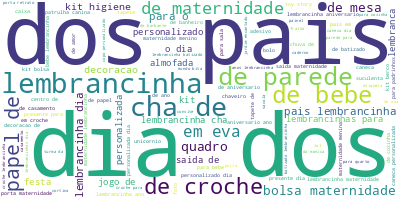

In [8]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [9]:
stop_words = []

with open('data/stopwords_portuguese', 'r') as reader:
    stop_words = [line.strip() for line in reader]

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [10]:
def text_preprocess(text):
    """
    1. remove pontuação
    2. remove stop words
    3. retorna lista de palavras resultante
    """
    
    sem_pontuacao = [char for char in text if char not in string.punctuation]    
    sem_pontuacao = ''.join(sem_pontuacao)    
    sem_stop_words = [word for word in sem_pontuacao.split() if word.lower() not in stop_words]
    
    words = []
    
    for index,word in enumerate(sem_stop_words):
        if word in ['lembrança', 'lembranças', 'lembrancinha', 'lembrancinhas', 'lembranca', 'lembrancas']:
            words.append('lembrancinhas')
        else:
            words.append(word)
    
    return words

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield text_preprocess(str(sentence))

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
data_words = list(sent_to_words(data['query'].values.tolist()))

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Create Dictionary
dictionary = corpora.Dictionary(data_words)

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Create Corpus
texts = data_words

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Bag of words

In [15]:
# Term Document Frequency
bow_corpus = [dictionary.doc2bow(text) for text in texts]
# View
print(bow_corpus[:1][0][:30])

[(0, 1), (1, 1)]


/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


## TF-IDF

In [16]:
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
from pprint import pprint
for doc in tfidf_corpus:
    pprint(doc)
    break

[(0, 0.7157241275832674), (1, 0.6983831134808249)]


/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Usar bow ou tfidf?

In [17]:
usar_tfidf = False

if not usar_tfidf:
    corpus = bow_corpus
else:
    corpus = tfidf_corpus

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [139]:
limit=50; start=1; step=1;

# Colocando parametros na função
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Mostrando visualmente a quantidade de tópicos
print(coherence_values)





100%|██████████| 49/49 [02:52<00:00,  3.53s/it]

[0.6206332419092978, 0.6098960084479835, 0.5882069141739855, 0.6187456860372017, 0.6207214378380483, 0.613416980101681, 0.6062507004858392, 0.5951522231500908, 0.5925404683053672, 0.5945877200360372, 0.6024926808809972, 0.598543909507465, 0.6041513824570374, 0.604684086110303, 0.6008814464788382, 0.6002050660859004, 0.5928275407371535, 0.5968158995178685, 0.6043638954719355, 0.5946802337205883, 0.6079077743995184, 0.5897249675356684, 0.5866540595657292, 0.5849412046575879, 0.5924586757676856, 0.5855880751537872, 0.5955463010218833, 0.5893570705215542, 0.5892045175564976, 0.5861857165031101, 0.5896142494211175, 0.5965493976971727, 0.5893794952876089, 0.5738106930346538, 0.5902413379653958, 0.585000865141983, 0.5788568972923505, 0.5848112632171556, 0.5717162651504661, 0.5648831799311982, 0.5565177932765406, 0.5593398952672514, 0.5513845629616271, 0.5566448099425597, 0.5512222098273677, 0.5515601189652357, 0.5523917491983361, 0.5512294587855897, 0.5602166203173706]


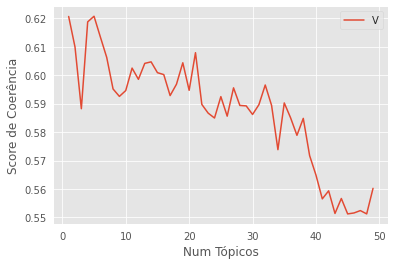

Num tópicos = 1  -> valor de coerência de  0.6206
Num tópicos = 2  -> valor de coerência de  0.6099
Num tópicos = 3  -> valor de coerência de  0.5882
Num tópicos = 4  -> valor de coerência de  0.6187
Num tópicos = 5  -> valor de coerência de  0.6207
Num tópicos = 6  -> valor de coerência de  0.6134
Num tópicos = 7  -> valor de coerência de  0.6063
Num tópicos = 8  -> valor de coerência de  0.5952
Num tópicos = 9  -> valor de coerência de  0.5925
Num tópicos = 10  -> valor de coerência de  0.5946
Num tópicos = 11  -> valor de coerência de  0.6025
Num tópicos = 12  -> valor de coerência de  0.5985
Num tópicos = 13  -> valor de coerência de  0.6042
Num tópicos = 14  -> valor de coerência de  0.6047
Num tópicos = 15  -> valor de coerência de  0.6009
Num tópicos = 16  -> valor de coerência de  0.6002
Num tópicos = 17  -> valor de coerência de  0.5928
Num tópicos = 18  -> valor de coerência de  0.5968
Num tópicos = 19  -> valor de coerência de  0.6044
Num tópicos = 20  -> valor de coerência 

In [141]:

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("Num tópicos =", m, " -> valor de coerência de ", round(cv, 4))

In [19]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)




# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.136*"lembrancinhas" + 0.029*"kit" + 0.028*"bebe" + 0.027*"batizado" + '
  '0.013*"quadro" + 0.013*"nascimento" + 0.012*"berco" + 0.011*"personalizado" '
  '+ 0.010*"formatura" + 0.010*"presente"'),
 (1,
  '0.043*"tapete" + 0.042*"croche" + 0.035*"lembrancinhas" + 0.027*"kit" + '
  '0.015*"berco" + 0.013*"capa" + 0.012*"higiene" + 0.010*"personalizadas" + '
  '0.010*"oval" + 0.009*"decoracao"'),
 (2,
  '0.108*"lembrancinhas" + 0.069*"maternidade" + 0.023*"festa" + '
  '0.023*"personalizada" + 0.018*"saida" + 0.013*"presente" + 0.012*"quadro" + '
  '0.011*"lol" + 0.011*"batizado" + 0.010*"caixa"'),
 (3,
  '0.083*"dia" + 0.079*"pais" + 0.042*"lembrancinhas" + 0.030*"casamento" + '
  '0.027*"croche" + 0.020*"cozinha" + 0.018*"caneca" + 0.018*"personalizado" + '
  '0.014*"caixa" + 0.014*"copo"'),
 (4,
  '0.095*"pais" + 0.092*"dia" + 0.065*"lembrancinhas" + 0.037*"personalizada" '
  '+ 0.030*"personalizado" + 0.027*"festa" + 0.015*"presente" + 0.013*"porta" '
  '+ 0.012*"infantil" 

In [20]:
%mkdir results

mkdir: cannot create directory ‘results’: File exists


/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/igorsr/Projetos/teste_elo7/venv_elo7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.121280 -0.041757       1        1  13.883610
7     -0.092081 -0.038926       2        1  11.396178
1     -0.093567  0.186450       3        1   9.772671
0     -0.047681 -0.010529       4        1   9.765089
3      0.161858  0.012888       5        1   9.714144
9      0.063274  0.067559       6        1   9.553861
5     -0.024982  0.012574       7        1   9.332094
6     -0.097668 -0.106501       8        1   9.294706
2     -0.055422 -0.060531       9        1   8.924851
8      0.064989 -0.021226      10        1   8.362797, topic_info=              Term         Freq        Total Category  logprob  loglift
14            pais  2717.000000  2717.000000  Default  30.0000  30.0000
13             dia  2836.000000  2836.000000  Default  29.0000  29.0000
19     maternidade  2312.000000  2312.000000  Default  28.0000  28.0000
18   lembrancinhas  6706.000000  6706.000000  Default  27.0000  27.0000
100          bolsa   599.000000   599.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
739         igreja    36.622711   169.563477  Topic10  -5.3634   0.9488
106      decoracao    56.939572   859.064061  Topic10  -4.9220  -0.2325
187        cozinha    44.076894   363.449208  Topic10  -5.1781   0.3717
46              15    43.650692   406.652783  Topic10  -5.1878   0.2496
109            kit    48.770705  1666.045089  Topic10  -5.0769  -1.0497

[768 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1920      1  0.158360     04
1920      5  0.791799     04
216       1  0.048249      1
216       2  0.088456      1
216       3  0.024124      1
...     ...       ...    ...
863       5  0.772830    yes
1769      2  0.833610   yoga
1769     10  0.104201   yoga
1414      2  0.152815  ziper
1414      6  0.764074  ziper

[2648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 2, 1, 4, 10, 6, 7, 3, 9])

## Classificação de algumas consultas aleatórias do dataset

In [144]:
linhas = data.sample(5, random_state=101)
consultas = linhas['query'].to_list()

consultas

['convite de aniversario digital',
 'embalagem para bem casado',
 'alice no pais das maravilhas',
 'babador bandana',
 'presente para o primeiro dia dos pais']

In [145]:
for consulta in consultas:
    
    print("Consulta: ", consulta)
    
    if not usar_tfidf:
        bow_vector = dictionary.doc2bow(text_preprocess(consulta))    

    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("\tScore: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    else:
        bow_vector = dictionary.doc2bow(text_preprocess(consulta))
        tfidf_vector = tfidf[bow_vector]    

        for index, score in sorted(lda_model[tfidf_vector], key=lambda tup: -1*tup[1]):
            print("\tScore: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
            
    print("\n\n")
    

Consulta:  convite de aniversario digital
	Score: 0.7748547196388245	 Topic: 0.114*"lembrancinhas" + 0.044*"personalizado" + 0.031*"aniversario" + 0.021*"casamento" + 0.014*"personalizados"
	Score: 0.025031251832842827	 Topic: 0.041*"personalizada" + 0.035*"lembrancinhas" + 0.034*"croche" + 0.025*"tapete" + 0.025*"banheiro"
	Score: 0.025029823184013367	 Topic: 0.074*"lembrancinhas" + 0.047*"dia" + 0.043*"pais" + 0.020*"canina" + 0.020*"patrulha"
	Score: 0.025019166991114616	 Topic: 0.046*"maternidade" + 0.036*"kit" + 0.036*"personalizada" + 0.035*"bebe" + 0.033*"lembrancinhas"
	Score: 0.025015264749526978	 Topic: 0.055*"maternidade" + 0.031*"menino" + 0.028*"lembrancinhas" + 0.027*"parede" + 0.024*"saida"
	Score: 0.02501513995230198	 Topic: 0.124*"lembrancinhas" + 0.027*"porta" + 0.025*"anos" + 0.024*"presente" + 0.021*"festa"
	Score: 0.02501213550567627	 Topic: 0.115*"lembrancinhas" + 0.075*"dia" + 0.072*"maternidade" + 0.069*"pais" + 0.020*"porta"
	Score: 0.025010082870721817	 Topic:

## Classificação de uma nova consulta

In [99]:
nova_consulta = ''

if not usar_tfidf:
    bow_vector = dictionary.doc2bow(text_preprocess(nova_consulta))    

    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
else:
    bow_vector = dictionary.doc2bow(text_preprocess(nova_consulta))
    tfidf_vector = tfidf[bow_vector]    

    for index, score in sorted(lda_model[tfidf_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    
    
    

Score: 0.5706213116645813	 Topic: 0.089*"lembrancinhas" + 0.055*"maternidade" + 0.032*"dia" + 0.026*"pais" + 0.026*"presente"
Score: 0.07173643261194229	 Topic: 0.042*"tapete" + 0.034*"personalizado" + 0.031*"lembrancinhas" + 0.025*"maternidade" + 0.024*"croche"
Score: 0.07166679948568344	 Topic: 0.132*"lembrancinhas" + 0.069*"pais" + 0.062*"dia" + 0.014*"caneca" + 0.011*"porta"
Score: 0.07152321934700012	 Topic: 0.040*"pais" + 0.039*"dia" + 0.025*"presente" + 0.023*"kit" + 0.023*"menina"
Score: 0.071522556245327	 Topic: 0.038*"lembrancinhas" + 0.033*"bebe" + 0.028*"decoracao" + 0.027*"parede" + 0.026*"anos"
Score: 0.07146799564361572	 Topic: 0.110*"lembrancinhas" + 0.067*"dia" + 0.059*"pais" + 0.043*"bebe" + 0.041*"maternidade"
Score: 0.0714617371559143	 Topic: 0.082*"lembrancinhas" + 0.056*"kit" + 0.027*"festa" + 0.027*"personalizada" + 0.018*"decoracao"
